In [221]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.sparse as sp
from scipy.optimize import minimize
import time
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

load some shared times (here just a single locus)

In [188]:
fname = '../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_polarized_masked_100000Ne_7e-9m_popsize_10numiter_0.5threshold_9966877-9969401bps_1000nsamples_sts.npy'
stss = np.load(fname)

load locations

In [3]:
locations = np.load('../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_locations.npy')
n = len(locations) #number of samples
Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1] #mean centering matrix
locations_centered = np.matmul(Tmat, locations)

some useful functions

In [4]:
def _anc_times(shared_times, ancestor_time, sample):
    
    taa = shared_times[0,0] - ancestor_time #shared time of ancestor with itself 

    anc_times = [] 
    for t in shared_times[sample]:
        anc_times.append(min(t, taa)) # shared times between ancestor and each sample lineage

    anc_times.append(taa) #add shared time with itself
        
    return np.array(anc_times)

In [19]:
def _log_birth_density(branching_times, phi, n, condition_on_n=True):
    """
    Log probability of branching times given Yule process with branching rate phi.
    """

    T = branching_times[-1] #storing total time as last entry for convenience
    n0 = n - (len(branching_times) - 1) #initial number of lineages (number of samples minus number of coalescence events)

    logp = 0 #initialize log probability
    prevt = 0 #initialize time
    k = n0 #initialize number of lineages
    # probability of each branching time
    for t in branching_times[:-1]: #for each branching time t
        logp += np.log(k * phi) - k * phi *  (t - prevt) #log probability of waiting time t-prevt with k lineages
        prevt = t #update time
        k += 1 #update number of lineages

    # probability of no branching from most recent branching to T
    logp += - k * phi * (T - prevt)

    # condition on having n samples from n0 in time T
    if condition_on_n:
        logp -= np.log(math.comb(k - 1, k - n0) * (1 - np.exp(-phi * T))**(k - n0)) - phi * n0 * T # see page 234 of https://www.pitt.edu/~super7/19011-20001/19531.pdf for two different expressions

    return logp

In [5]:
def _lognormpdf(x, mu, S):

    """
    Calculate log probability density of x, when x ~ N(mu,S)
    """

    norm_coeff = np.linalg.slogdet(S)[1] #just care about relative likelihood so drop the constant

    # term in exponential (times -2)
    err = x - mu #difference between mean and data
    if sp.issparse(S):
        numerator = spln.spsolve(S, err).T.dot(err) #use faster sparse methods if possible
    else:
        numerator = np.linalg.solve(S, err).T.dot(err) #just a fancy way of calculating err.T * S^-1  * err

    return -0.5 * (norm_coeff + numerator) #add the two terms together and multiply by -1/2

In [43]:
def _logsumexp(a):
    """
    Take the log of a sum of exponentials without losing information.
    """

    a_max = np.max(a) #max element in list a
    tmp = np.exp(a - a_max) #now subtract off the max from each a before taking exponential (ie divide sum of exponentials by exp(a_max))
    s = np.sum(tmp) #and sum those up
    out = np.log(s) #and take log
    out += a_max  #and then add max element back on (ie multiply sum by exp(a_max), ie add log(exp(a_max)) to logged sum)

    return out

In [7]:
def chop_shared_times(shared_times, tCutoff=None):

    k = len(shared_times) #total number of samples
    samples = np.arange(k) #list of samples (assumes the shared times are ordered already)

    # if we don't need to cut then just return a single matrix and associated samples
    T = shared_times[0,0] #tmrca

    if tCutoff is None or tCutoff>T:
        return [shared_times], [samples]

    # if we do have to cut
    shared_times_sinceT = tCutoff - (T-shared_times) #calculate shared time since tCutoff

    # and now the harder part of grouping times and samples for each subtree 
    sts = [] #list of shared times matrices for each subtree
    smpls = [] #list of samples in each subtree
    taken = [False for _ in range(k)] #keep track of which samples already in a subtree
    while sum(taken) < k: #while some samples not yet in a subtree
        i = np.argmax(taken == False) #choose next sample, i, not yet in a subtree
        withi = shared_times_sinceT[i] >= 0 #samples which share time with i
        taken = np.array([i[0] or i[1] for i in zip(taken, withi)]) #update which samples taken
        stsi = shared_times_sinceT[withi][:, withi] #shared times of subtree with i
        smplsi = samples[np.where(withi)[0]] #samples in this subtree
        sts.append(stsi)
        smpls.append(smplsi)

    return sts, smpls

In [9]:
def _get_focal_index(focal_node, listoflists):

    """
    get the subtree and index within that subtree for focal_node (listoflists here is list of samples for each subtree)
    """

    for i,j in enumerate(listoflists):
        if focal_node in j:
            n = i
            for k,l in enumerate(j):
                if focal_node == l:
                    m = k
    return n,m

mle dispersal rate and branching rate

In [339]:
Ne = 1e5 #prior Ne
m = '7e-9' #prior mutation rate
numiter = 10 #number of MCMC iterations in estimating Ne
threshold = 0.5 #fraction of trees to drop when estimating Ne
nsamples = 1000 #number of trees per locus
fname = '../data/T2T_Athaliana_66.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
fname = fname %(Ne, m, numiter, threshold) + '_1000nsamples_%stCutoff_mle-dispersal.npy'
mle = np.load(fname %'None', allow_pickle=True)
sigma = np.array([[mle[0]**2, mle[2]*mle[0]*mle[1]], [mle[2]*mle[0]*mle[1], mle[1]**2]]) #mle dispersal rate
phi = mle[-1] #branching rate

## one tree

choose a single tree and invert the shared time matrix

In [7]:
shared_times = stss[0]
shared_times_inverted = np.linalg.pinv(shared_times)

and calculate mle mrca location

In [8]:
numer = np.matmul(np.matmul(np.ones(n),shared_times_inverted),locations)
denom = np.matmul(np.matmul(np.ones(n),shared_times_inverted),np.ones(n).transpose())
mrca_loc = numer/denom
mrca_loc

array([-0.45360104, 39.50508029])

note that the first sample is located at 

In [9]:
sample = 0
locations[sample]

array([13.5603, 55.9419])

if we take the ancestor time to be zero the ancestor should be located at the sample

In [10]:
ancestor_time = 0 #generations ago
anc_times = _anc_times(shared_times, ancestor_time, sample)

In [11]:
mrca_loc + np.matmul(np.matmul(anc_times[:-1], shared_times_inverted), locations-mrca_loc)

array([13.5603, 55.9419])

if we take the time to be the tmrca the ancestor should be located at the mrca

In [12]:
ancestor_time = shared_times[0,0]
anc_times = _anc_times(shared_times, ancestor_time, sample)

In [13]:
mrca_loc + np.matmul(np.matmul(anc_times[:-1], shared_times_inverted), locations-mrca_loc) 

array([-0.45360104, 39.50508029])

and we can plot in between

In [14]:
times = np.logspace(np.log10(1),np.log10(shared_times[0,0]),100)
anc_locs = []
for ancestor_time in times:
    anc_times = _anc_times(shared_times, ancestor_time, sample)
    anc_loc = mrca_loc + np.matmul(np.matmul(anc_times[:-1], shared_times_inverted), locations-mrca_loc) 
    anc_locs.append(anc_loc)
anc_locs = np.array(anc_locs)

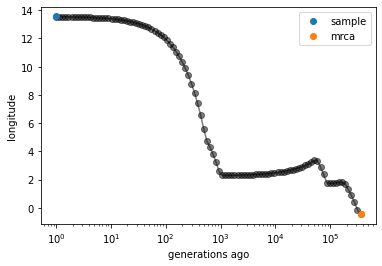

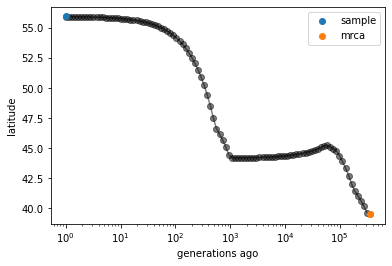

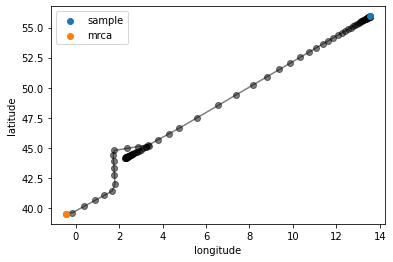

In [15]:
plt.plot(times, anc_locs[:,0],'o-',c='k',alpha=0.5,zorder=0)
plt.scatter(times[0],locations[sample,0],label='sample')
plt.scatter(times[-1],mrca_loc[0],label='mrca')
plt.xlabel('generations ago')
plt.ylabel('longitude')
plt.legend()
plt.xscale('log')
plt.show()

plt.plot(times, anc_locs[:,1],'o-',c='k',alpha=0.5,zorder=0)
plt.scatter(times[0],locations[sample,1],label='sample')
plt.scatter(times[-1],mrca_loc[1],label='mrca')
plt.xlabel('generations ago')
plt.ylabel('latitude')
plt.legend()
plt.xscale('log')
plt.show()

plt.plot(anc_locs[:,0],anc_locs[:,1],'o-',c='k',alpha=0.5,zorder=0)
plt.scatter(locations[sample,0],locations[sample,1],label='sample')
plt.scatter(mrca_loc[0],mrca_loc[1],label='mrca')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
plt.show()

we can also calculate the variance in the ancestors location

In [16]:
ancestor_time = 0 #generations ago
anc_times = _anc_times(shared_times, ancestor_time, sample)
anc_times[-1] - np.matmul(np.matmul(anc_times[:-1], shared_times_inverted), anc_times[:-1].transpose()) 

-1.1420343071222305e-07

In [17]:
ancestor_time = shared_times[0,0] #generations ago
anc_times = _anc_times(shared_times, ancestor_time, sample)
anc_times[-1] - np.matmul(np.matmul(anc_times[:-1], shared_times_inverted), anc_times[:-1].transpose()) 

0.0

but this is clearly wrong, as we get no variance at the root. this is because this method assumes the root is known with certainty. we therefore need to either add the variance in the root, or mean center.

first try mean centering

In [18]:
shared_times_centered = np.matmul(Tmat, np.matmul(shared_times, np.transpose(Tmat))) #mean centered covariance of samples
shared_times_centered_inverted = np.linalg.pinv(shared_times_centered)

In [19]:
ancestor_time = 1e4 #generations ago
anc_times = _anc_times(shared_times, ancestor_time, sample)
# anc_times_centered = np.matmul(Tmat, anc_times[:-1]) - np.matmul( np.matmul(Tmat, shared_times), np.ones(n).reshape(-1,1))/n
# anc_times_centered = np.matmul(Tmat, (anc_times[:-1].reshape(-1,1) - np.matmul(shared_times, np.ones(n).reshape(-1,1))/n))
anc_times_centered = np.matmul(Tmat, (anc_times[:-1] - np.mean(shared_times, axis=1)))

In [20]:
# alltimes = np.zeros((n+1,n+1))
# alltimes[0,0] = anc_times[-1] #element in first row and column
# alltimes[0,1:] = anc_times[:-1] #remainder of first row
# alltimes[1:,0] = anc_times[:-1] #remainder of first column
# alltimes[1:,1:] = shared_times #remainder of matrix

# x = np.array([[1] + [-1/n] * n]) #vector to mean center ancestors variance
# taa_centered = np.matmul(np.matmul(x, alltimes), x.transpose())

taa_centered = anc_times[-1] - 2*np.mean(anc_times[:-1]) + np.mean(shared_times)

and then get mle ancestor location

In [21]:
np.mean(locations, axis=0) + np.matmul(np.matmul(anc_times_centered.transpose(), shared_times_centered_inverted), locations_centered)

array([ 2.47784505, 44.35100514])

and the proper variance

In [22]:
(taa_centered - np.matmul(np.matmul(anc_times_centered.transpose(), shared_times_centered_inverted), anc_times_centered)) * sigma

array([[31.26130111, 13.58493731],
       [13.58493731, 23.93452044]])

evaluate for a number of times

In [23]:
times = np.logspace(np.log10(1),np.log10(shared_times[0,0]),100)
anc_locs = []
anc_vars = []
for ancestor_time in times:
    anc_times = _anc_times(shared_times, ancestor_time, sample)
    anc_times_centered = np.matmul(Tmat, (anc_times[:-1].reshape(-1,1) - np.matmul(shared_times, np.ones(n).reshape(-1,1))/n))
    alltimes = np.zeros((n+1,n+1))
    alltimes[0,0] = anc_times[-1] #element in first row and column
    alltimes[0,1:] = anc_times[:-1] #remainder of first row
    alltimes[1:,0] = anc_times[:-1] #remainder of first column
    alltimes[1:,1:] = shared_times #remainder of matrix
    x = np.array([[1] + [-1/n] * n]) #vector to mean center ancestors variance
    taa_centered = np.matmul(np.matmul(x, alltimes), x.transpose())
    anc_loc = np.mean(locations, axis=0) + np.matmul(np.matmul(anc_times_centered.transpose(), shared_times_centered_inverted), locations_centered)
    anc_locs.append(anc_loc[0])
    anc_var = (taa_centered - np.matmul(np.matmul(anc_times_centered.transpose(), shared_times_centered_inverted), anc_times_centered)) * sigma
    anc_vars.append(anc_var)
anc_locs = np.array(anc_locs)
anc_vars = np.array(anc_vars)

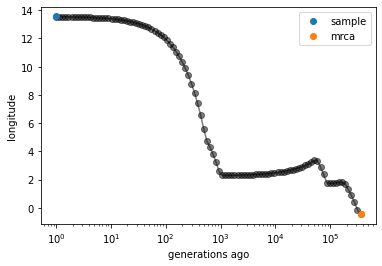

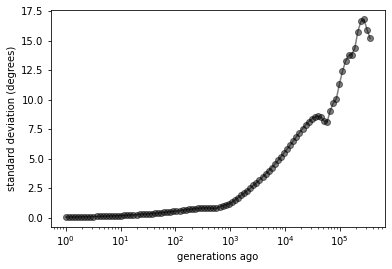

In [24]:
plt.plot(times, anc_locs[:,0],'o-',c='k',alpha=0.5,zorder=0)
plt.scatter(times[0],locations[sample,0],label='sample')
plt.scatter(times[-1],mrca_loc[0],label='mrca')
plt.xlabel('generations ago')
plt.ylabel('longitude')
plt.legend()
plt.xscale('log')
plt.show()

plt.plot(times, anc_vars[:,0,0]**0.5,'o-',c='k',alpha=0.5,zorder=0)
# plt.scatter(times[0],locations[sample,0],label='sample')
# plt.scatter(times[-1],mrca_loc[0],label='mrca')
plt.xlabel('generations ago')
plt.ylabel('standard deviation (degrees)')
# plt.legend()
plt.xscale('log')
plt.show()

now that we have the mean and variance of ancestor location, we have its likelihood. the next steps are 1) to average the mles over trees (BLUP) and 2) to find the average distribution over trees, weighted by importance, then numerically find the mle.

## multiple trees - BLUP

first prep our shared times (not we already have the centered-inverses on file from the dispersal rate search)

In [61]:
M = 10
shared_times = stss[:M]

In [62]:
shared_times_centered_inverted = []
for st in shared_times:
    stc = np.matmul(Tmat, np.matmul(st, np.transpose(Tmat))) #mean centered covariance of samples
    stci = np.linalg.pinv(stc)
    shared_times_centered_inverted.append(stci)
shared_times_centered_inverted = np.array(shared_times_centered_inverted)

then get centered ancestor times

In [63]:
ancestor_time = 1e4
sample = 0

anc_times_centered = []
taa_centered = []
for st in shared_times:
    at = _anc_times(st, ancestor_time, sample)
    atc = np.matmul(Tmat, (at[:-1] - np.mean(st, axis=1)))
    anc_times_centered.append(atc)
    taac = at[-1] - 2*np.mean(at[:-1]) + np.mean(st)
    taa_centered.append(taac)
anc_times_centered = np.array(anc_times_centered)
taa_centered = np.array(taa_centered)

and mle and var in ancestor locations for each tree

In [64]:
mle_locs = []
var_locs = []

for stci, atc, taac in zip(shared_times_centered_inverted, anc_times_centered, taa_centered):

    mle_loc = np.mean(locations, axis=0) + np.matmul(np.matmul(atc.transpose(), stci), locations_centered)
    mle_locs.append(mle_loc)
    
    var_loc = (taac - np.matmul(np.matmul(atc.transpose(), stci), atc)) * sigma
    var_locs.append(var_loc)
    
mle_locs = np.array(mle_locs)
var_locs = np.array(var_locs)

we could take a simple average

In [65]:
np.mean(mle_locs, axis=0)

array([ 3.05971262, 45.01008758])

or weight by inverse variance ("precision-weighted")

In [66]:
sumCinv = 0
sumCinvx = np.zeros(2)
for mle_loc, var_loc in zip(mle_locs, var_locs):
    Cinv = np.linalg.inv(var_loc)
    sumCinv += Cinv
    sumCinvx += np.matmul(Cinv, mle_loc)  
np.matmul(np.linalg.inv(sumCinv), sumCinvx)

array([ 3.01185376, 44.96296875])

better-yet, we should weight by importance weights

In [67]:
fname = '../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_polarized_masked_100000Ne_7e-9m_popsize_10numiter_0.5threshold_9966877-9969401bps_1000nsamples_cts_NonetCutoff_lpcs.npy'
lpcs = np.load(fname, allow_pickle=True).astype(float)

In [68]:
fname = '../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_polarized_masked_100000Ne_7e-9m_popsize_10numiter_0.5threshold_9966877-9969401bps_1000nsamples_cts_NonetCutoff_bts.npy'
btss = np.load(fname, allow_pickle=True).astype(float)

In [70]:
lbds = [_log_birth_density(bts, phi, n) for bts in btss]

In [71]:
numer = np.sum([mle_loc * np.exp(lbd - lpc) for mle_loc,lpc,lbd in zip(mle_locs, lpcs[:M], lbds[:M])], axis=0)
denom = np.sum([np.exp(lbd - lpc) for lpc,lbd in zip(lpcs[:M], lbds[:M])])
numer/denom

array([ 2.8112437 , 44.73316141])

## multiple trees -- numerical mle

now we search for the true mle

In [39]:
fs = []

for mle_loc, var_loc in zip(mle_locs, var_locs):

    fs.append(lambda x: _lognormpdf(x, mle_loc, var_loc))

In [41]:
def g(x):
    return -_logsumexp([f(x) for f in fs])

In [43]:
minimize(g, x0=locations[sample])

      fun: 0.6451690165771624
 hess_inv: array([[24.67090628, 10.98910892],
       [10.98910892, 19.2025461 ]])
      jac: array([-8.34465027e-07,  5.96046448e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([ 3.72764581, 45.66274645])

how long does this take with 1000 trees?

In [45]:
shared_times = stss

In [46]:
shared_times_centered_inverted = []
for st in shared_times:
    stc = np.matmul(Tmat, np.matmul(st, np.transpose(Tmat))) #mean centered covariance of samples
    stci = np.linalg.pinv(stc)
    shared_times_centered_inverted.append(stci)
shared_times_centered_inverted = np.array(shared_times_centered_inverted)

In [47]:
ancestor_time = 1e4
sample = 0

anc_times_centered = []
taa_centered = []
for st in shared_times:
    at = _anc_times(st, ancestor_time, sample)
    atc = np.matmul(Tmat, (at[:-1] - np.mean(st, axis=1)))
    anc_times_centered.append(atc)
    taac = at[-1] - 2*np.mean(at[:-1]) + np.mean(st)
    taa_centered.append(taac)
anc_times_centered = np.array(anc_times_centered)
taa_centered = np.array(taa_centered)

In [48]:
mle_locs = []
var_locs = []

for stci, atc, taac in zip(shared_times_centered_inverted, anc_times_centered, taa_centered):

    mle_loc = np.mean(locations, axis=0) + np.matmul(np.matmul(atc.transpose(), stci), locations_centered)
    mle_locs.append(mle_loc)
    
    var_loc = (taac - np.matmul(np.matmul(atc.transpose(), stci), atc)) * sigma
    var_locs.append(var_loc)
    
mle_locs = np.array(mle_locs)
var_locs = np.array(var_locs)

In [49]:
fs = []

for mle_loc, var_loc in zip(mle_locs, var_locs):

    fs.append(lambda x: _lognormpdf(x, mle_loc, var_loc))

In [50]:
def g(x):
    return -_logsumexp([f(x) for f in fs])

In [51]:
t0 = time.time()
print(minimize(g, x0=locations[sample]))
print(time.time()-t0)

      fun: -4.043368945982673
 hess_inv: array([[22.43270487, 10.2798793 ],
       [10.2798793 , 17.59034546]])
      jac: array([-9.00030136e-06,  7.86781311e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([ 2.34228247, 44.25165678])
0.5842595100402832


great, very fast

now to add importance weights

In [56]:
def g(x):
    return -_logsumexp([f(x) + lbd - lpc for f,lbd,lpc in zip(fs, lbds, lpcs)])

In [57]:
t0 = time.time()
print(minimize(g, x0=locations[sample]))
print(time.time()-t0)

      fun: -36.05959094637875
 hess_inv: array([[22.45566157, 10.28902715],
       [10.28902715, 17.58377219]])
      jac: array([-7.62939453e-06,  7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([ 2.34229635, 44.2516401 ])
0.622014045715332


## time cutoffs

final step -- deal with chopped off trees

In [341]:
tCutoff = int(1e4)

In [342]:
Ne = 1e5 #prior Ne
m = '7e-9' #prior mutation rate
numiter = 10 #number of MCMC iterations in estimating Ne
threshold = 0.5 #fraction of trees to drop when estimating Ne
nsamples = 1000 #number of trees per locus
fname = '../data/T2T_Athaliana_66.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
fname = fname %(Ne, m, numiter, threshold) + '_1000nsamples_%dtCutoff_mle-dispersal.npy'
mle = np.load(fname %tCutoff, allow_pickle=True)
sigma = np.array([[mle[0]**2, mle[2]*mle[0]*mle[1]], [mle[2]*mle[0]*mle[1], mle[1]**2]]) #mle dispersal rate
phi = mle[-1]

we can load the importance weights

In [23]:
fname = '../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_polarized_masked_100000Ne_7e-9m_popsize_10numiter_0.5threshold_9966877-9969401bps_1000nsamples_cts_%dtCutoff_lpcs.npy' %tCutoff
lpcs = np.load(fname, allow_pickle=True).astype(float)

In [24]:
fname = '../data/T2T_Athaliana_66.Chr1.nomissing.nohet.justSNPs_haploid_polarized_masked_100000Ne_7e-9m_popsize_10numiter_0.5threshold_9966877-9969401bps_1000nsamples_cts_%dtCutoff_bts.npy' %tCutoff
btss = np.load(fname, allow_pickle=True)

In [25]:
lbds = [_log_birth_density(bts, phi, n) for bts in btss]

but to get the ancestor times, and center them, we need the chopped shared times

In [190]:
stss_chopped = []
samples = []
for sts in stss:
    sts_chopped, smpls = chop_shared_times(sts, tCutoff=tCutoff)
    stss_chopped.append(sts_chopped)
    samples.append(smpls)

choose the sample and get the subtree properties

In [139]:
sample = 0

stss = []
stcis = []
locss = []
lcs = []
js = []
for sts, smpls in tqdm(zip(stss_chopped, samples), total=len(samples)):

    i,j = _get_focal_index(sample, smpls) #subtree and index of sample
    js.append(j)
    st = sts[i] #shared times in subtree
    stss.append(st)
    n = len(st); 
    # note that if n=1, we get lots of empty matrices below, but the mle and var are calculated correctly (sample location and sigma*t respectively)

    Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1] #mean centering matrix
    stc = np.matmul(Tmat, np.matmul(st.astype(float), np.transpose(Tmat))) #center shared times matrix
    stci = np.linalg.inv(stc) #invert (we have these in file, for dispersal rate, but probably faster to calculate than load?)
    stcis.append(stci)
    
    locs = locations[smpls[i]]
    locss.append(locs)
    lc = np.matmul(Tmat, locs)
    lcs.append(lc)

100%|██████████| 1000/1000 [00:00<00:00, 6454.86it/s]


choose the time and get the likelihoods

In [143]:
ancestor_time = 1e3 #max not greater than tCutoff

fs = []
for st,stci,locs,lc,j in tqdm(zip(stss, stcis, locss, lcs, js), total=len(stss)):
    
    at = _anc_times(st, ancestor_time, j) #shared times between samples and ancestor
    n = len(st); Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1] #mean centering matrix
    atc = np.matmul(Tmat, (at[:-1] - np.mean(st, axis=1))) #center this
    taac = at[-1] - 2*np.mean(at[:-1]) + np.mean(st) #center shared times of ancestor with itself

    mle_loc = np.mean(locs, axis=0) + np.matmul(np.matmul(atc.transpose(), stci), lc)
    var_loc = (taac - np.matmul(np.matmul(atc.transpose(), stci), atc)) * sigma
    fs.append(lambda x: _lognormpdf(x, mle_loc, var_loc))

100%|██████████| 1000/1000 [00:00<00:00, 13240.31it/s]


find the mle

In [144]:
def g(x): return -_logsumexp([f(x) + lbd - lpc for f,lbd,lpc in zip(fs, lbds, lpcs)])
minimize(g, x0=locations[sample])

      fun: -51.54979053134616
 hess_inv: array([[4.29745769, 2.45173734],
       [2.45173734, 3.41683015]])
      jac: array([-1.90734863e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([ 8.23094213, 50.28200051])

now how to do this efficiently for 1) multiple times and 2) multiple samples?

1) lets move a few more things up into the first loop

In [161]:
sample = 0

sts = []
stmrs = []
stms = []
stcis = []
locs_means = []
stcilcs = []
js = []
for stsc, smpls in tqdm(zip(stss_chopped, samples), total=len(samples)):

    i,j = _get_focal_index(sample, smpls) #subtree and index of sample
    js.append(j)
    st = stsc[i] #shared times in subtree
    sts.append(st)
    stmr = np.mean(st, axis=1)
    stmrs.append(stmr)
    stm = np.mean(st)
    stms.append(stm)
    n = len(st); 
    # note that if n=1, we get lots of empty matrices below, but the mle and var are calculated correctly (sample location and sigma*t respectively)

    Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1] #mean centering matrix
    stc = np.matmul(Tmat, np.matmul(st.astype(float), np.transpose(Tmat))) #center shared times matrix
    stci = np.linalg.inv(stc) #invert (we have these in file, for dispersal rate, but probably faster to calculate than load?)
    stcis.append(stci)
    
    locs = locations[smpls[i]]
    locs_mean = np.mean(locs, axis=0)
    locs_means.append(locs_mean)
    lc = np.matmul(Tmat, locs)
    stcilc = np.matmul(stci, lc)
    stcilcs.append(stcilc)

100%|██████████| 1000/1000 [00:00<00:00, 5099.09it/s]


and then loop over times

In [182]:
ancestor_times = np.logspace(1,4,4) #max not greater than tCutoff

for ancestor_time in ancestor_times:

    fs = []
    for st,stmr,stm,stci,lm,stcilc,j in zip(sts, stmrs, stms, stcis, locs_means, stcilcs, js):

        n = len(st); Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1] #mean centering matrix

        # only below depends on ancestor_time and j
        at = _anc_times(st, ancestor_time, j) #shared times between samples and ancestor
        atc = np.matmul(Tmat, (at[:-1] - stmr)) #center this
        taac = at[-1] - 2*np.mean(at[:-1]) + stm #center shared times of ancestor with itself

        mle_loc = lm + np.matmul(atc.transpose(), stcilc) #mean loc
        var_loc = (taac - np.matmul(np.matmul(atc.transpose(), stci), atc)) * sigma #variance in loc
        fs.append(lambda x: _lognormpdf(x, mle_loc, var_loc)) #append likelihood
        
    # find min of negative of log of summed likelihoods (weighted by importance)
    def g(x): return -_logsumexp([f(x) + lbd - lpc for f,lbd,lpc in zip(fs, lbds, lpcs)])
    x0 = locations[sample] + (np.mean(locs_means, axis=0) - locations[sample])/tCutoff*ancestor_time #best linear guess
    mle = minimize(g, x0=x0).x
    print(sample, mle, ancestor_time)

0 [13.50700657 55.88530113] 10.0
0 [13.02736583 55.37591169] 100.0
0 [ 8.23095048 50.28200719] 1000.0
0 [ 2.0700588  43.97694015] 10000.0


2) scaling up to multiple samples is a bit tricky with time cutoffs because a given pair of samples may or may not be in the same subtree across trees. this means that we basically have to just parallelize the above code across samples. this leaves us with a lot of jobs to run, if we want to locate every sample at every locus

In [183]:
66*878

57948

we could try just looping over samples at a locus then, if this isn't too slow

In [327]:
def locate_ancestors(ancestor_samples, ancestor_times, 
                     shared_times_chopped, samples, locations, sigma, log_weights, 
                     x0_final=None):

    all_ancestor_locations = []
    for sample in tqdm(ancestor_samples):

        sts = []
        stmrs = []
        stms = []
        stcis = []
        locs_means = []
        stcilcs = []
        js = []
        for stsc, smpls in zip(shared_times_chopped, samples):

            i,j = _get_focal_index(sample, smpls) #subtree and index of sample
            js.append(j)
            st = stsc[i] #shared times in subtree
            sts.append(st)
            stmr = np.mean(st, axis=1)
            stmrs.append(stmr)
            stm = np.mean(st)
            stms.append(stm)
            n = len(st); 
            # note that if n=1, we get lots of empty matrices below, but the mle and var are calculated correctly (sample location and sigma*t respectively)

            Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1] #mean centering matrix
            stc = np.matmul(Tmat, np.matmul(st.astype(float), np.transpose(Tmat))) #center shared times matrix
            stci = np.linalg.inv(stc) #invert (we have these in file, for dispersal rate, but probably faster to calculate than load?)
            stcis.append(stci)

            locs = locations[smpls[i]]
            locs_mean = np.mean(locs, axis=0)
            locs_means.append(locs_mean)
            lc = np.matmul(Tmat, locs)
            stcilc = np.matmul(stci, lc)
            stcilcs.append(stcilc)

        ancestor_locations = locations[sample]
        for ancestor_time in ancestor_times:

            fs = []
            for st,stmr,stm,stci,lm,stcilc,j in zip(sts, stmrs, stms, stcis, locs_means, stcilcs, js):

                n = len(st); Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1] #mean centering matrix

                # only below depends on ancestor_time and j
                at = _anc_times(st, ancestor_time, j) #shared times between samples and ancestor
                atc = np.matmul(Tmat, (at[:-1] - stmr)) #center this
                taac = at[-1] - 2*np.mean(at[:-1]) + stm #center shared times of ancestor with itself
                mle_loc = lm + np.matmul(atc.transpose(), stcilc) #mean loc
                var_loc = (taac - np.matmul(np.matmul(atc.transpose(), stci), atc)) * sigma #variance in loc
                fs.append(lambda x: _lognormpdf(x, mle_loc, var_loc)) #append likelihood

            # find min of negative of log of summed likelihoods (weighted by importance)
            def g(x): 
                return -_logsumexp([f(x) + log_weight for f,log_weight in zip(fs, log_weights)])
            x0 = locations[sample] 
            if x0_final is not None:
                x0 = x0 + (x0_final - x0)*ancestor_time/ancestor_times[-1] #best linear guess
            mle = minimize(g, x0=x0).x
            ancestor_locations = np.vstack([ancestor_locations,mle])

        all_ancestor_locations.append(ancestor_locations)
        
    return np.array(all_ancestor_locations)

In [301]:
log_weights = lbds - lpcs

In [330]:
ancestor_samples = range(len(locations))
ancestor_times = np.logspace(1,4,4) #max not greater than tCutoff

all_ancestor_locations = locate_ancestors(ancestor_samples, ancestor_times, 
                                          stss_chopped, samples, locations, sigma, log_weights)

100%|██████████| 66/66 [01:18<00:00,  1.19s/it]


great, this doesn't take too long, so let's just run this for each locus via snakemake

and a test at plotting:

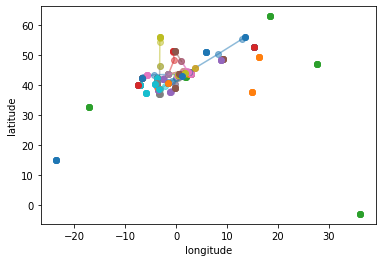

In [332]:
ancestor_samples = range(66)

for sample in ancestor_samples:
    plt.plot(all_ancestor_locations[sample,:,0],all_ancestor_locations[sample,:,1],'o-',alpha=0.5,zorder=0)
    plt.scatter(locations[sample,0],locations[sample,1])

plt.xlabel('longitude')
plt.ylabel('latitude')
# plt.legend()
plt.show()

why not on a map with bells and whistles

In [333]:
ids = []
ids_file='../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid.samples' %1
with open(ids_file, mode='r') as file:
    next(file); next(file) #skip header and 0 row
    for line in file: 
        ids.append(line.strip().split(' ')[0])

metadata = []
with open('../data/66_genomes_summary.txt','r') as file:
    next(file) #skip header
    for line in file:
        metadata.append(line.strip().split('\t'))
        
accessions = [i[1].strip().replace('_','.').split('.')[0].replace('"','') for i in metadata]
accessions2 = [i[3] for i in metadata]

order = []
for id in ids:
    try:
        ix = accessions.index(id)
    except:
        ix = accessions2.index(id)
    order.append(ix)

group = np.array([i[2] for i in metadata])[order]
population_names, population_ixs = np.unique(group, return_inverse=True)

In [334]:
colors = px.colors.qualitative.G10[:len(population_names)]

In [335]:
fig = go.Figure()

for sample in ancestor_samples:
    fig.add_trace(go.Scattergeo(lon=all_ancestor_locations[sample,:,0],
                                lat=all_ancestor_locations[sample,:,1],
                                hoverinfo='text',
                                hovertext=ids[sample],
                                mode='markers+lines',
                                line = dict(width = 2, color=colors[population_ixs[sample]]),
                                opacity=0.5,
#                                 legendgroup=group[sample],
                                name=group[sample]
                               ))

fig.update_layout(
    geo = dict(
        scope = 'world',
        showland = True,
        landcolor = "rgb(232, 232, 232)",
#         subunitcolor = "rgb(255, 255, 255)",
#         countrycolor = "rgb(255, 255, 255)",
#         showlakes = True,
#         lakecolor = "rgb(255, 255, 255)",
#         showsubunits = True,
        showcountries = True,
        resolution = 50,
#         projection = dict(
#             type = 'conic conformal',
#             rotation_lon = meanlon
#         ),
        projection_type = "equirectangular",
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ min(locations[:,0])-1, max(locations[:,0])+1 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
#             range= [ min(locations[:,1])-1, max(locations[:,1])+1 ],
            range= [ 30, max(locations[:,1])+1 ],
            dtick = 5
        )
    ),
    legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="left",
    x=0.125,
    bgcolor='rgba(0,0,0,0)',
#    bordercolor="Black",
#   borderwidth=1
    ),
    legend_title_text='',
#     showlegend=False
)
names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
        if (trace.name in names) else names.add(trace.name))
fig.show()
# fig.write_image(plotdir + 'locations.png')

ok, looks like we are ready to do this across loci via snakemake

In [354]:
np.logspace(1,np.log10(1e6),10)

array([1.00000000e+01, 3.59381366e+01, 1.29154967e+02, 4.64158883e+02,
       1.66810054e+03, 5.99484250e+03, 2.15443469e+04, 7.74263683e+04,
       2.78255940e+05, 1.00000000e+06])

In [355]:
np.load('../data/T2T_Athaliana_66.nomissing.nohet.justSNPs_haploid_polarized_masked_100000Ne_7e-9m_popsize_10numiter_0.5threshold_1000nsamples_1000000tCutoff_mle-dispersal.npy')

array([6.15313738e-02, 5.38557214e-02, 4.96940622e-01, 2.72295924e-05])